In [110]:
import pandas as pd
pd.set_option('display.max_rows', 15)  # or use a specific number
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import math
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

**EXPLORATORY DATA ANALYSIS** PREDICTING PULMONARY EDEMA

In [111]:
''' 
Obtaining data
'''

from ucimlrepo import fetch_ucirepo 
pd.set_option('display.max_rows', None)
  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
df = myocardial_infarction_complications.data.original 
X_full = myocardial_infarction_complications.data.features[:] 
y_full = myocardial_infarction_complications.data.targets[:] 

X = X_full[:]
y = y_full[:]
  
# metadata 
#print(myocardial_infarction_complications.metadata) 
  
# variable information 
vars = myocardial_infarction_complications.variables


In [124]:
'''
Observing NaNs
'''
X_nan_number = X.isna().sum().sort_values(ascending=False)
X_nan_percentage = X_nan_number/1700

print(X_nan_percentage)

KFK_BLOOD     0.997647
IBS_NASL      0.957647
D_AD_KBRIG    0.632941
S_AD_KBRIG    0.632941
NOT_NA_KB     0.403529
                ...   
zab_leg_04    0.004118
NA_R_1_n      0.002941
INF_ANAM      0.002353
IM_PG_P       0.000588
SEX           0.000000
Length: 111, dtype: float64


In [115]:
''' 
Organizing features for future use
'''
names_binary_feats = np.array(vars[(vars['type']=='Binary') & (vars['role']=='Feature')].name)
names_cat_feats = np.array(vars[(vars['type']=='Categorical') & (vars['role']=='Feature')].name)
names_int_feats = np.array(vars[(vars['type']=='Integer') & (vars['role']=='Feature')].name)
names_cont_feats = np.array(vars[(vars['type']=='Continuous') & (vars['role']=='Feature')].name)


In [116]:
pd.set_option('display.max_rows', None)  # or use a specific number
pd.set_option('display.max_columns', None)

feature_names = vars[(vars['type'] == 'Binary') & (vars['role'] == 'Feature')]['name'].tolist()
print(feature_names)

# feature_data = vars[vars['role'] == 'Feature'][['description', 'name', 'type']]
# feature_data.to_csv('feature_names.csv', index=True)
# col_headers = vars[vars['role']=='Feature'].description
# list_headers = [x for x in col_headers]
# print(list_headers)

# col_headers = vars[vars['role']=='Target'].description
# list_headers = [x for x in col_headers]
# print(list_headers)

#print(vars[['name','description','type']])

pd.set_option('display.max_rows', 15)  # or use a specific number



['SEX', 'IBS_NASL', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'GIPER_NA', 'NA_KB', 'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', '

In [117]:
pd.set_option('display.max_colwidth', None)
target_names = np.array(vars.loc[vars['role']=='Target'].name)
#vars.loc[vars['name']=='OTEK_LANC']
#y.value_counts()
y_full['OTEK_LANC'].value_counts()

#set target variable to be pulmonary edema
y = y_full['OTEK_LANC']

In [118]:
import seaborn as sns
''' 
Measuring Pearson Correlations
'''

#X_filtered = X.drop(columns=['KFK_BLOOD'])
X_filtered = X[:]
mat = X_filtered.corr(method='pearson', min_periods=1, numeric_only=False)

# Assuming 'mat' is your correlation matrix
threshold = 0.8

# Create a boolean mask for correlations greater than the threshold
mask = (mat.abs() > threshold) & (mat != 1)  # Exclude self-correlation

# Get the pairs of features that meet the criteria
high_corr_pairs = mat[mask]

# Convert to a long format for easier reading
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# print(high_corr_pairs.iloc[::2])
# print(type(high_corr_pairs))

sorted_pairs = high_corr_pairs.iloc[::2].sort_values(by='Correlation', ascending=False)

# Add descriptions for Feature1
sorted_pairs['Feature1_Description'] = sorted_pairs['Feature1'].map(
    lambda x: vars.loc[vars['name'] == x, 'description'].values[0] if not vars.loc[vars['name'] == x, 'description'].empty else None
)

# Add descriptions for Feature2
sorted_pairs['Feature2_Description'] = sorted_pairs['Feature2'].map(
    lambda x: vars.loc[vars['name'] == x, 'description'].values[0] if not vars.loc[vars['name'] == x, 'description'].empty else None
)

# Display the sorted DataFrame with descriptions
sorted_pairs

,Feature1,Feature2,Correlation,Feature1_Description,Feature2_Description
22,KFK_BLOOD,LID_KB,1.000000,Serum CPK content,Use of lidocaine by the Emergency Cardiology Team
24,NA_KB,KFK_BLOOD,1.000000,Use of opioid drugs by the Emergency Cardiology Team,Serum CPK content
14,KFK_BLOOD,FK_STENOK,0.985329,Serum CPK content,Functional class (FC) of angina pectoris in the last year. \n\n0: there is no angina pectoris\n\n1: I FC\n\n2: II FC\n\n3: III FC\n\n4: IV FC
0,STENOK_AN,KFK_BLOOD,0.985329,Exertional angina pectoris in the anamnesis. \n\n0: never\n\n1: during the last year \n\n2: one year ago\n\n3: two years ago\n\n4: three years ago\n\n5: 4-5 years ago,Serum CPK content
2,ZSN_A,KFK_BLOOD,0.973729,"Presence of chronic Heart failure (HF) in the anamnesis: Partially ordered attribute: there are two lines of severities:\n\n0<1<2<4,\n\n0<1<3<4.\n\nState 4 means simultaneous states 2 and 3\n\n\n\n0: there is no chronic heart failure\n\n1: I stage\n\n2: II stage (heart failure due to right \n\nventricular systolic dysfunction)\n\n3: II stage (heart failure due to left \n\nventricular systolic dysfunction)\n\n4: IIB stage (heart failure due to left and\n\n right ventricular systolic dysfunction)",Serum CPK content
16,KFK_BLOOD,endocr_02,0.973729,Serum CPK content,Obesity in the anamnesis
20,KFK_BLOOD,L_BLOOD,0.926228,Serum CPK content,White blood cell count
6,S_AD_ORIT,D_AD_ORIT,0.861266,Systolic blood pressure according to intensive care unit,Diastolic blood pressure according to intensive care unit
8,D_AD_ORIT,S_AD_ORIT,0.861266,Diastolic blood pressure according to intensive care unit,Systolic blood pressure according to intensive care unit
10,MP_TP_POST,ritm_ecg_p_02,0.845695,"Paroxysms of atrial fibrillation at the time of admission to intensive care unit, (or at a pre-hospital stage)",ECG rhythm at the time of admission to hospital: atrial fibrillation


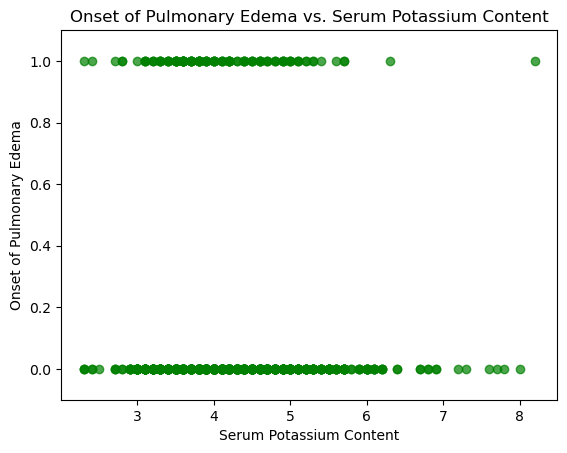

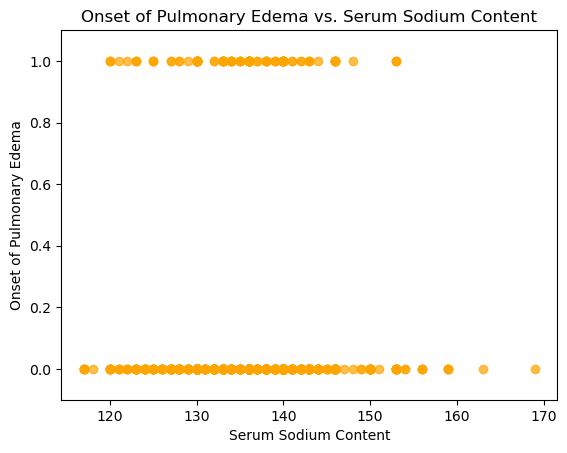

In [119]:
''' 
Looking at serum concentration
'''
plt.scatter(X['K_BLOOD'], df['OTEK_LANC'], color='green', alpha=0.7)
plt.title('Onset of Pulmonary Edema vs. Serum Potassium Content')
plt.xlabel('Serum Potassium Content')
plt.ylabel('Onset of Pulmonary Edema')
plt.ylim(-0.1, 1.1)  # Adjust y-limits for clarity
plt.show()

plt.scatter(X['NA_BLOOD'], df['OTEK_LANC'], color='orange', alpha=0.7)
plt.title('Onset of Pulmonary Edema vs. Serum Sodium Content')
plt.xlabel('Serum Sodium Content')
plt.ylabel('Onset of Pulmonary Edema')
plt.ylim(-0.1, 1.1)  # Adjust y-limits for clarity
plt.show()

/var/folders/sd/_g49jm097m1ccf0r7dhzypt00000gn/T/ipykernel_66814/587180932.py:18: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x[df['OTEK_LANC'] == 1], y[df['OTEK_LANC'] == 1],


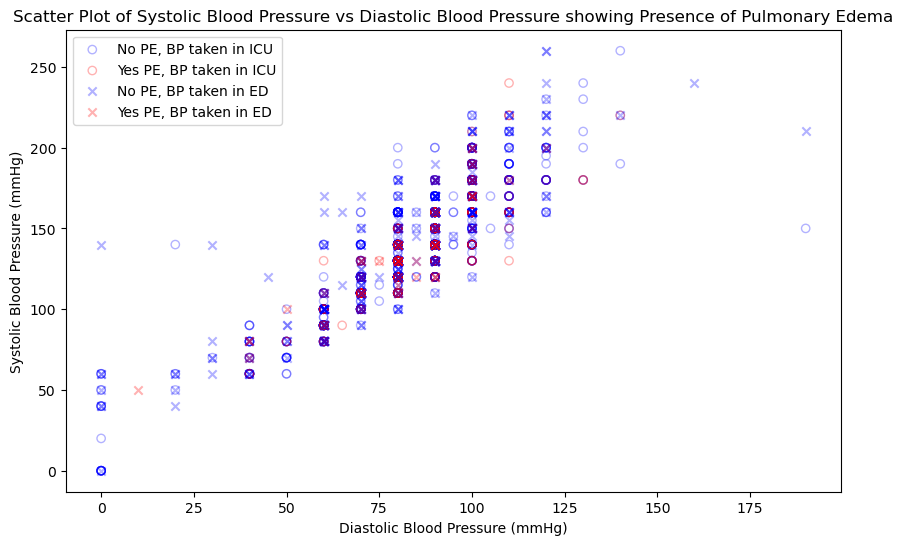

In [ ]:
''' 
Blood pressure observations by class
'''
plt.figure(figsize=(10, 6))
#ICU
x = df['D_AD_ORIT']
y = df['S_AD_ORIT']

plt.scatter(x[df['OTEK_LANC'] == 0], y[df['OTEK_LANC'] == 0], 
            facecolor='none', edgecolor='blue', label='OTEK_LANC = 0', alpha=0.3, marker = 'o')

plt.scatter(x[df['OTEK_LANC'] == 1], y[df['OTEK_LANC'] == 1], 
            facecolor='none', edgecolor='red', label='OTEK_LANC = 1', alpha=0.3, marker = 'o')

#emergency cardiology
x = df['D_AD_KBRIG']
y = df['S_AD_KBRIG']
plt.scatter(x[df['OTEK_LANC'] == 0], y[df['OTEK_LANC'] == 0], 
            color='blue', label='OTEK_LANC = 0', alpha=0.3, marker = 'x')

plt.scatter(x[df['OTEK_LANC'] == 1], y[df['OTEK_LANC'] == 1], 
            color='red', edgecolor='red', label='OTEK_LANC = 1', alpha=0.3, marker = 'x')

#Labels and title
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.title('Scatter Plot of Systolic Blood Pressure vs Diastolic Blood Pressure showing Presence of Pulmonary Edema')
plt.legend(['No PE, BP taken in ICU', 'Yes PE, BP taken in ICU', 'No PE, BP taken in ED', 'Yes PE, BP taken in ED'])  
plt.savefig('bp vs pe.png', dpi=300)
plt.show()

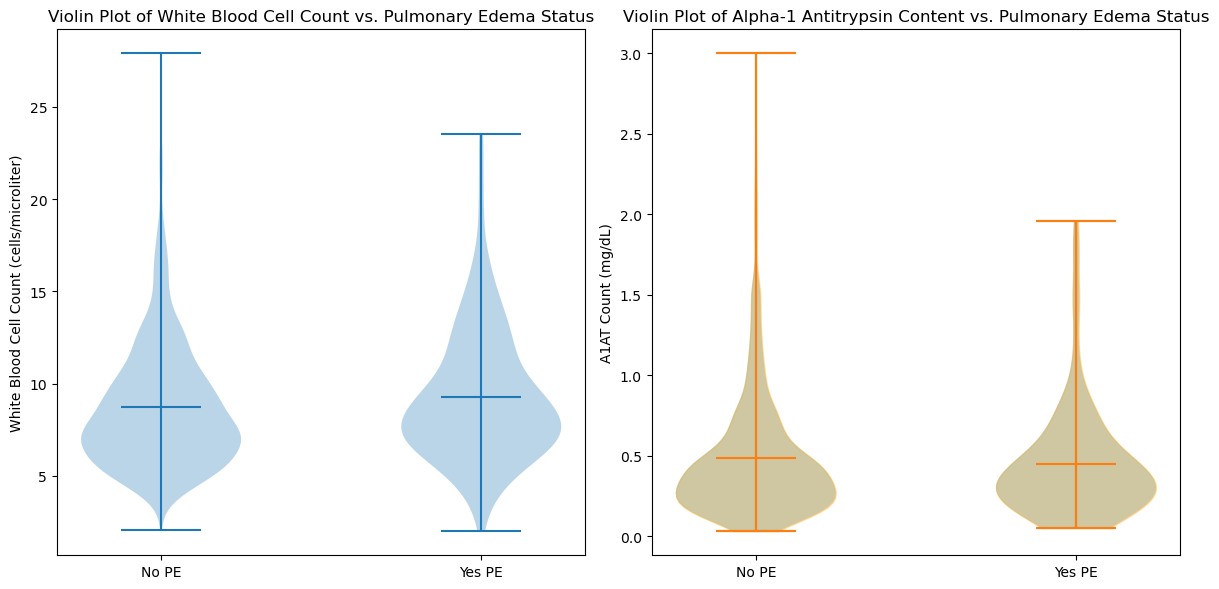

In [122]:
''' 
More serum concentrations
'''
#Prepare the datasets
dataset_wbc = [
    df[df['OTEK_LANC'] == 0]['L_BLOOD'].dropna().values,
    df[df['OTEK_LANC'] == 1]['L_BLOOD'].dropna().values
]

dataset_a1at = [
    df[df['OTEK_LANC'] == 0]['ALT_BLOOD'].dropna().values,
    df[df['OTEK_LANC'] == 1]['ALT_BLOOD'].dropna().values
]

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

#First subplot: wbc
axs[0].violinplot(dataset=dataset_wbc, showmeans=True, showmedians=False)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['No PE', 'Yes PE'])
axs[0].set_ylabel('White Blood Cell Count (cells/microliter)')
axs[0].set_title('Violin Plot of White Blood Cell Count vs. Pulmonary Edema Status')

#Second subplot: a1ac
axs[1].violinplot(dataset=dataset_a1at)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['No PE', 'Yes PE'])
axs[1].set_ylabel('A1AT Count (mg/dL)')
axs[1].set_title('Violin Plot of Alpha-1 Antitrypsin Content vs. Pulmonary Edema Status')

parts = plt.violinplot(dataset=dataset_a1at, showmeans=True, showmedians=False)

parts['bodies'][0].set_facecolor('orange')  
parts['bodies'][1].set_facecolor('orange')  
parts['bodies'][0].set_edgecolor('orange')  
parts['bodies'][1].set_edgecolor('orange')  

plt.tight_layout()
plt.savefig('wbc and a1at.png', dpi=300)
plt.show()



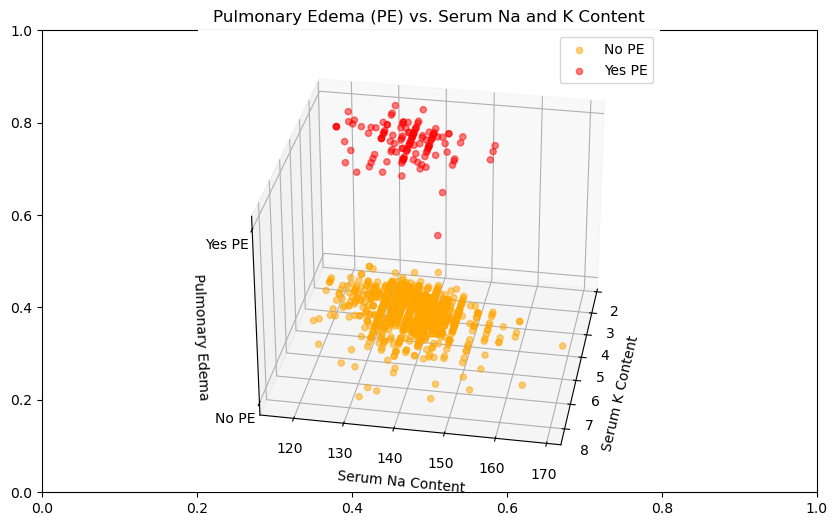

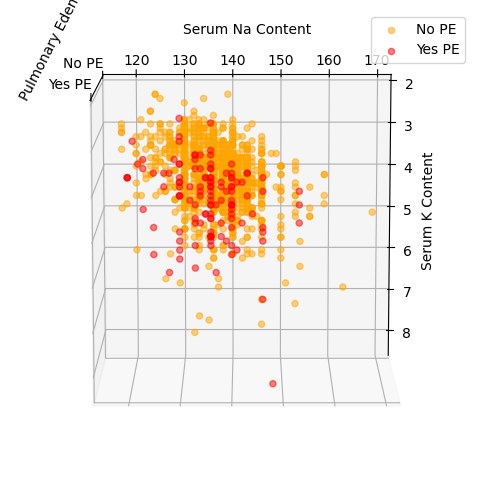

In [ ]:
''' 
Combining serum ion concentrations into one plot
'''
from mpl_toolkits.mplot3d import Axes3D

y = df['OTEK_LANC']

#Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
plt.title('Pulmonary Edema (PE) vs. Serum Na and K Content')
ax = fig.add_subplot(111, projection='3d')

# Separate the points based on the binary target variable
ax.scatter(X['K_BLOOD'][y == 0],X['NA_BLOOD'][y == 0], y[y == 0], color='orange', alpha = 0.5, label='No PE')
ax.scatter(X['K_BLOOD'][y == 1], X['NA_BLOOD'][y == 1], y[y == 1], color='red', alpha = 0.5, label='Yes PE')

#Labels
ax.set_xlabel('Serum K Content')
ax.set_ylabel('Serum Na Content')
ax.set_zticks([0,1], ['No PE', 'Yes PE'])
ax.set_zlabel('Pulmonary Edema')
ax.view_init(elev=30, azim=10)
ax.legend()
plt.savefig('ions', dpi = 300)

plt.show()

#--
#Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Separate the points based on the binary target variable
ax.scatter(X['K_BLOOD'][y == 0], X['NA_BLOOD'][y == 0], y[y == 0], color='orange', alpha = 0.5, label='No PE')
ax.scatter(X['K_BLOOD'][y == 1], X['NA_BLOOD'][y == 1], y[y == 1], color='red', alpha = 0.5, label='Yes PE')

#Labels
ax.set_xlabel('Serum K Content')
ax.set_ylabel('Serum Na Content')
ax.set_zticks([0,1], ['No PE', 'Yes PE'])
ax.set_zlabel('Pulmonary Edema')
ax.view_init(elev=100, azim=0)
ax.legend()

plt.show()

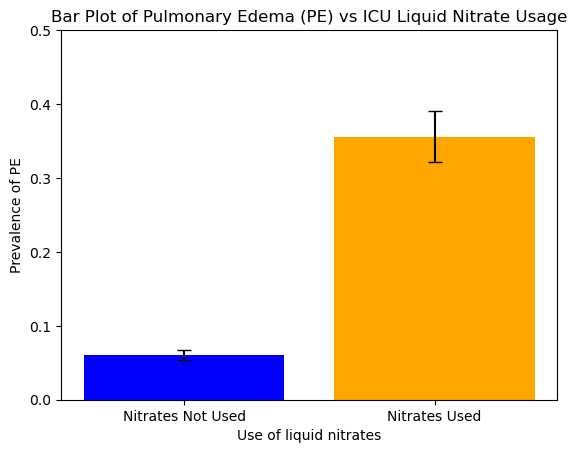

In [ ]:
'''  
Liquid nitrate usage
'''

mean_values = y.groupby(X['NITR_S']).mean()
sem_values = y.groupby(X['NITR_S']).sem()

plt.bar(mean_values.index, mean_values.values, yerr=sem_values.values, capsize=5, color=['blue', 'orange'])
plt.xlabel('Use of liquid nitrates')
plt.ylabel('Prevalence of PE')
plt.title('Bar Plot of Pulmonary Edema (PE) vs ICU Liquid Nitrate Usage')
plt.xticks([0, 1], labels=['Nitrates Not Used', 'Nitrates Used'])  
plt.ylim(0, 0.5) 
plt.savefig('liqnit.png', dpi = 300)
plt.show()

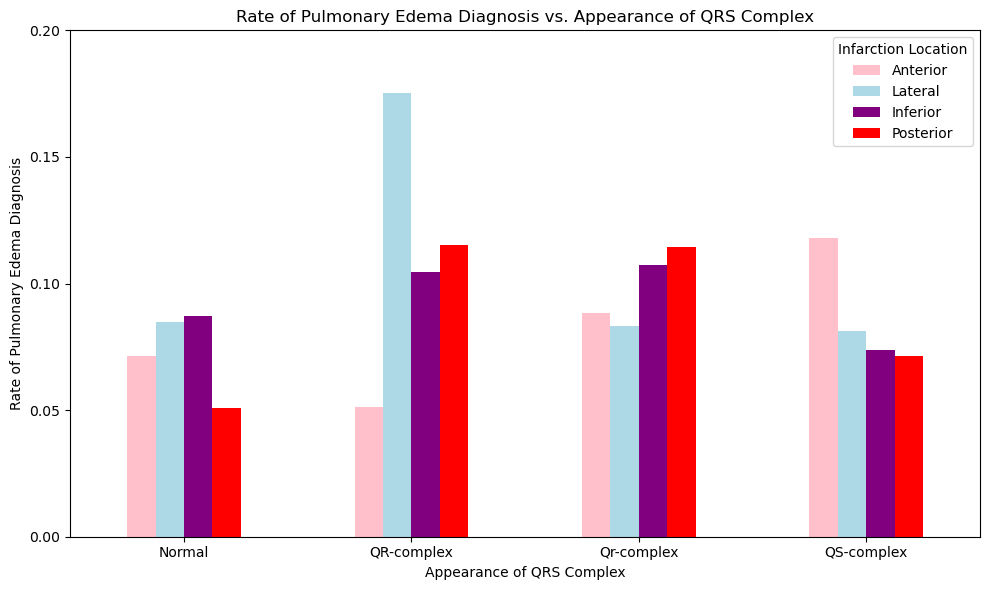

In [69]:
''' 
Data organized by QRS and by location of infarction
'''

count_data = pd.DataFrame({
    'OTEK_LANC': df['OTEK_LANC'],
    'ant_im': df['ant_im'],
    'lat_im': df['lat_im'],
    'inf_im': df['inf_im'],
    'post_im': df['post_im']
})

#Calculate mean PE for each feature value
means = {}
for column in ['ant_im', 'lat_im', 'inf_im', 'post_im']:
    means[column] = count_data.groupby(column)['OTEK_LANC'].mean()

mean_df = pd.DataFrame(means)
mean_df = mean_df.iloc[1:,:]

colors = ['pink', 'lightblue', 'purple', 'red']  # Customize your colors
mean_df.plot(kind='bar', figsize=(10, 6), color=colors)

# Labels and title
plt.title('Rate of Pulmonary Edema Diagnosis vs. Appearance of QRS Complex')
plt.xlabel('Appearance of QRS Complex')
plt.ylabel('Rate of Pulmonary Edema Diagnosis')
plt.ylim(0, 0.2)  # Set y-axis limits
plt.yticks(ticks=[0.0,0.05,0.1,0.15,0.2])
plt.xticks(rotation=0, ticks=[0.0, 1.0, 2.0,3.0], labels = ['Normal','QR-complex', 'Qr-complex', 'QS-complex'])  # Keep x-ticks horizontal
plt.legend(['Anterior', 'Lateral','Inferior','Posterior'], title='Infarction Location')
plt.tight_layout()
plt.savefig('pe vs infarction location.png', dpi=300, bbox_inches='tight')

plt.show()


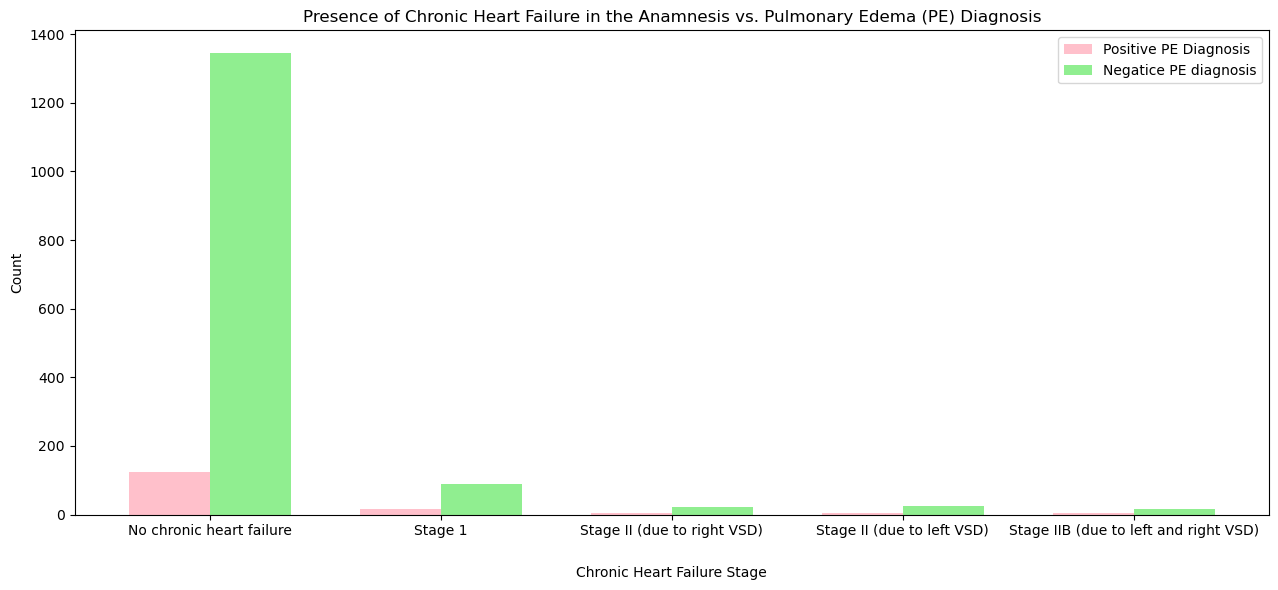

In [104]:
''' 
Chronic Heart Failure
'''
zsn_pos = df['ZSN_A'].loc[df['OTEK_LANC']==1].dropna()
zsn_neg = df['ZSN_A'].loc[df['OTEK_LANC']==0].dropna()

bar_pos_values = []
bar_neg_values = []
for i in range(5):
    bar_pos_values.append(np.sum(zsn_pos==i))
    bar_neg_values.append(np.sum(zsn_neg==i))

index = np.arange(5)
fig, ax = plt.subplots(figsize=(13, 6))
bar_width = 0.35

# Plot the bars
bar1 = ax.bar(index, bar_pos_values, bar_width, label='Positive PE Diagnosis', color='pink')
bar2 = ax.bar(index + bar_width, bar_neg_values, bar_width, label='Negatice PE diagnosis', color='lightgreen')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Chronic Heart Failure Stage', labelpad=20)
ax.set_ylabel('Count')
ax.set_title('Presence of Chronic Heart Failure in the Anamnesis vs. Pulmonary Edema (PE) Diagnosis')
ax.set_xticks(index + bar_width / 2)  # Center the ticks between the bars
ax.set_xticklabels(['No chronic heart failure','Stage 1','Stage II (due to right VSD)','Stage II (due to left VSD)', 'Stage IIB (due to left and right VSD)'])

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig('ZSN vs PE.png', dpi=300)
plt.show()

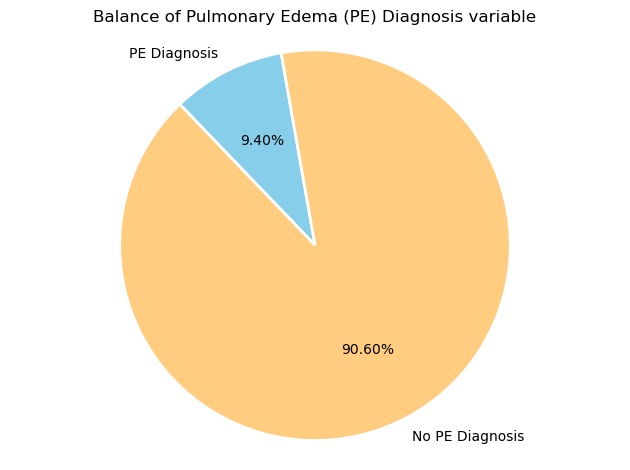

In [70]:
''' 
Target variable distribution
'''

# Remove rows where AGE is nan
for ftr in ['AGE']:
    valid_index = X[X[ftr].notna()].index
    X = X.loc[valid_index]
    y = y.loc[valid_index]

count_1 = sum(y==1)
count_0 = sum(y==0)

# Create the pie chart
labels = ['PE Diagnosis', 'No PE Diagnosis']
sizes = [count_1, count_0]
colors = ['skyblue', '#FFCC80']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=100, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
plt.title('Balance of Pulmonary Edema (PE) Diagnosis variable')
plt.axis('equal')
plt.tight_layout()
plt.savefig('target_values_piechart.png', dpi=300, bbox_inches='tight')

plt.show()
